<a href="https://colab.research.google.com/github/bimewok/Strava_Data_Visualization/blob/main/Animated_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Ben Garrett<br>
Created Date: 12/28/2020

*The following article is written as a Jupyter Notebook. All code can be run and tweaked by clicking the 'Open in Colab' button.*

# Introduction

Time series data naturally lends itself to animations as a user can watch a measure change as the year progresses. Building these charts can be a bit tricky, though. The `Matplotlib` library of Python contains some useful tools to create and export animated charts as *gifs* or *mp4s*. In this article, I will show some of these features using my Strava activity data from 2020. More info on the data and how it was collected can be found in my other post [Visualizing My Strava Data with Python and Tableau](https://bimewokdata.blogspot.com/2021/03/gist.html). 

## Imports

The data coves from a csv downloaded from Strava where each row is an activity (hike, run, ride) that I logged in 2020. The attributes are relevant measures like elevation gain, speed, etc.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick
import calendar
import requests, io
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.animation as animation
from matplotlib import rc
!pip install MoviePy
rc('animation', html='jshtml')


activity_details_url = """
https://raw.githubusercontent.com/bimewok/Strava_Data_Visualization/main/data/ActivityDetails%20(2).csv"""
activities = requests.get(activity_details_url).content
    
data = pd.read_csv(io.StringIO(activities.decode('utf-8')))
path_to_save = ''

## Clean The Data

The following code creates several cumulative sum columns for seeing annual progress of the metrics of interest. In this case, the metrics are elevation gain (feet), duration of activity (hours) and distance (miles). 

In [ ]:
data['Activity Date'] = pd.to_datetime(data['Activity Date'])

data = data[(data['Activity Date'] >= '2020-1-1') & 
            (data['Activity Date'] <= \
             '2021-1-1')].sort_values('Activity Date').reset_index()

for i in range(len(data['Total Time'])):
    data.loc[i, 'Total Time'] = pd.Timedelta(data['Total Time'][i]) / \
            np.timedelta64(1, 'h')

    
    

data['elev_running'] = data['Elevation Gain'].cumsum()
data['duration_running'] = data['Total Time'].cumsum()
data['distance_running'] = data['Distance'].cumsum()
data['day'] = data['Activity Date'].dt.dayofyear
data['month'] = data['Activity Date'].dt.month
data['month'] = data['month'].apply(lambda x: calendar.month_abbr[x])

## Create Static Chart of Progress Over Time 

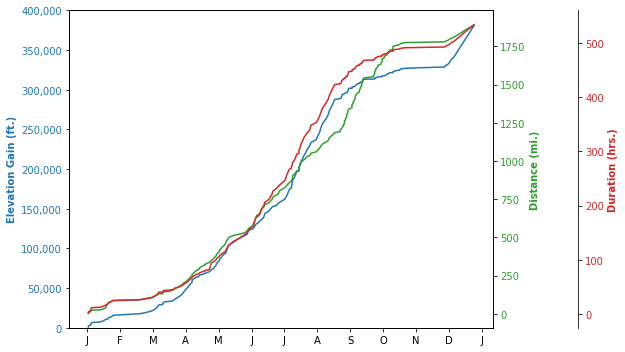

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 5))

color = 'tab:blue'
#ax1.set_xlabel('date')
ax1.set_xticks(np.linspace(0.0, 365, num=13))



ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 
                     'A', 'S', 'O', 'N', 'D', 'J'])
ax1.set_ylabel('Elevation Gain (ft.)', color=color, fontweight='bold')
ax1.plot(data['day'], data['elev_running'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 400000)
#ax1.set_yticks([0, ])

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Distance (mi.)', color=color, fontweight='bold') 
# we already handled the x-label with ax1 
ax2.plot(data['day'], data['distance_running'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()

color = 'tab:red'
ax3.set_ylabel('Duration (hrs.)', color=color, fontweight='bold')
# we already handled the x-label with ax1  
ax3.plot(data['day'], data['duration_running'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.spines["right"].set_position(("axes", 1.2))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Create Animated GIF of Progress Over Time

Tho following code builds the same chart, but displays a gif where each frame is the above chart at each time step. For the chart to animate very smoothly, you would need to pad values to ensure there is representation for each timestep in the dataset, however for simplicity I did not do this here. The basic steps are as follows:
- scale all measures to the same value range (min - max scale is easiest) for comparison
- Initialize a figure
- Generate empty plots for each measure
- Create an 'init' function that Matplotlib will recognize as the base formatting for the animated chart
- Create an 'update' function that defines what Matplotlib should do for each timestep. In this case, the y-axis lists are simply updated with the appropriate value at each time step. 
- Create the animation. This function of Matplotlib takes the two functions and outputs a chart object.
- Write the video file. There are multiple ways to save the animation; in this case, I used PillowWriter to export a gif. 

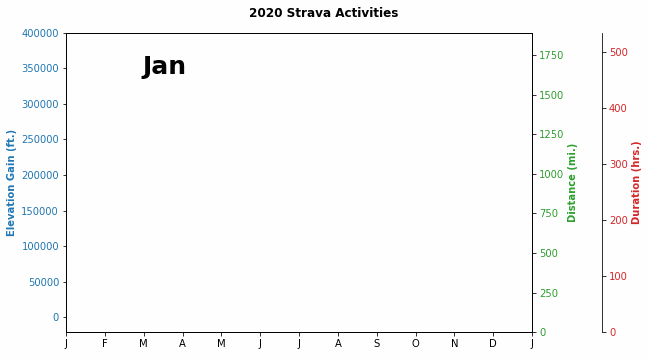

In [ ]:
e_max = max(data['elev_running'])
d_max = max(data['distance_running'])
t_max = max(data['duration_running'])

data['elev_running'] = data['elev_running'] / e_max
data['distance_running'] = data['distance_running'] / d_max
data['duration_running'] = data['duration_running'] / t_max

e_lab = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]
d_lab = [0, 250, 500, 750, 1000, 1250, 1500, 1750]
t_lab = [0, 100, 200, 300, 400, 500]

from matplotlib.animation import FuncAnimation, PillowWriter  
fig, ax1 = plt.subplots(figsize=(9, 5)) 
fig.tight_layout(rect=(0.05, 0, 0.85, 0.95))

x, lin1, lin2, lin3 = [], [], [], []  
ln1, = plt.plot([], [], color='tab:blue')  
ln2, = plt.plot([], [], color='tab:green')
ln3, = plt.plot([], [], color='tab:red')
date_text = ax1.text(60., 0.9, '', fontsize=25, fontweight='bold')
def init():  
    fig.suptitle('2020 Strava Activities', fontweight='bold')
    ax1.set_xticks(np.linspace(0.0, 365, num=13))
    ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 
                         'S', 'O', 'N', 'D', 'J'])
    ax1.set_ylabel('Elevation Gain (ft.)', color='tab:blue', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_yticks([i/e_max for i in e_lab])
    ax1.set_yticklabels(e_lab)
    
    ax2 = ax1.twinx()
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_yticks([i/d_max for i in d_lab])
    ax2.set_ylabel('Distance (mi.)', color='tab:green', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_yticklabels(d_lab)
    
    ax3 = ax1.twinx()
    ax3.set_yticks([i/t_max for i in t_lab])
    ax3.set_ylabel('Duration (hrs.)', color='tab:red', fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='tab:red')
    ax3.spines["right"].set_position(("axes", 1.15))
    ax3.set_yticklabels(t_lab)

  
def update(i):  
    x.append(data['day'][i])  
    lin1.append(data['elev_running'][i])  
    lin2.append(data['distance_running'][i])  
    lin3.append(data['duration_running'][i])
    ln1.set_data(x, lin1)  
    ln2.set_data(x, lin2)  
    ln3.set_data(x, lin3)
    date_text.set_text(data['month'][i])
    
ani = FuncAnimation(fig, update, len(data)-1, init_func=init)  
writer = PillowWriter(fps=10)  
ani.save('test.gif', writer=writer) 
plt.close()

Image(open('test.gif','rb').read())


## Creating More Complex Animations

The above chart is great at showing the distribution of my activities over time. Additionally, you can see differences in my average speed when the distance and duration lines diverge (relative slow down of my activities) and converge (speed up of my activities). We can make this much more apparent by charting cumulative means as opposed to sums. This will explicitly show how my speed, distance per activity and duration per activity varied as the year progressed. The below code:
 - Separates activities by activity type and calculates the cumulative mean for each represented day
 -  Pads the dataset to create null activities for unrepresented days. This allows ensures there is a data point for each day, whether or not there was an activity, to allow for smooth animation.
 - Creates empty plots for each metric, and empty lines for each metric and each activity type
 - Creates init and update functions like above to generate the animation
 - Saves output as mp4 instead of gif (no particular reason, just testing different export options) 
 - Displays output inline and runs the video in a loop of 300 iterations

In [ ]:

data['Total Time'] = data['Total Time'].astype('float')

hiking_means = pd.DataFrame({'date': data[data['Type'] == 'Hike']['day']})
hiking_means[['Distance (mi.)', 'Elev Gain (ft.)', 'Speed (mph)', 'Duration (hrs.)']] = \
data[data['Type'] == 'Hike'][['Distance', 'Elevation Gain', 'Avg Speed', 'Total Time']].expanding().mean()
hiking_means = hiking_means.reset_index().drop(['index'], axis=1)

biking_means = pd.DataFrame({'date': data[data['Type'] == 'Ride']['day']})
biking_means[['Distance (mi.)', 'Elev Gain (ft.)', 'Speed (mph)', 'Duration (hrs.)']] = \
data[data['Type'] == 'Ride'][['Distance', 'Elevation Gain', 'Avg Speed', 'Total Time']].expanding().mean()
biking_means = biking_means.reset_index().drop(['index'], axis=1)

running_means = pd.DataFrame({'date': data[data['Type'] == 'Run']['day']})
running_means[['Distance (mi.)', 'Elev Gain (ft.)', 'Speed (mph)', 'Duration (hrs.)']] = \
data[data['Type'] == 'Run'][['Distance', 'Elevation Gain', 'Avg Speed', 'Total Time']].expanding().mean()
running_means = running_means.reset_index().drop(['index'], axis=1)

def pad_data(data):
    days = [*range(365)]
    for i in range(len(data)):
        day = data['date'][i]
        try:
            days.remove(day)
        except:
            pass
    for i in days:
        data = data.append({'date':i}, ignore_index=True)
    data = pd.DataFrame(data.groupby('date').max())
    data = data.sort_values('date').reset_index()
    data = data.fillna(method='ffill')
    data = data.fillna(0)
    return data

hiking_means = pad_data(hiking_means)
running_means = pad_data(running_means)
biking_means = pad_data(biking_means)

def sort(data):
    data = data.sort_values('date')
    return data

hiking_means = sort(hiking_means)
running_means = sort(running_means)
biking_means = sort(biking_means)


#cols = ['Distance (mi.)', 'Elev Gain (ft.)', 'Speed (mph)', 'Duration (hrs.)']



#maxes = hiking_means.append(running_means)
#maxes = maxes.append(biking_means)






fig, ax = plt.subplots(4,1, figsize=(10, 12), sharex=False) 
fig.subplots_adjust(top=0.94, hspace=0.26)

x1, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12 = [], [], [], [], [], [], [], [], [], [], [], [], []
ln1, = ax[0].plot([], [], color='tab:blue')  
ln2, = ax[0].plot([], [], color='tab:green')
ln3, = ax[0].plot([], [], color='tab:red')

ln4, = ax[1].plot([], [], color='tab:blue')  
ln5, = ax[1].plot([], [], color='tab:green')
ln6, = ax[1].plot([], [], color='tab:red')

ln7, = ax[2].plot([], [], color='tab:blue')  
ln8, = ax[2].plot([], [], color='tab:green')
ln9, = ax[2].plot([], [], color='tab:red')

ln10, = ax[3].plot([], [], color='tab:blue')  
ln11, = ax[3].plot([], [], color='tab:green')
ln12, = ax[3].plot([], [], color='tab:red')

def init():  
    fig.suptitle('2020 Strava Cumulative Means\n')
    ax[0].set_xticks(np.linspace(0.0, 365, num=13))
    ax[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
    ax[0].set_ylabel('Distance (mi.)', fontweight='bold')
    ax[0].set_title('Distance', fontweight='bold')   
    ax[0].legend([ln1, ln2, ln3], ['Hike','Run','Bike'], loc='upper right')
    ax[0].set_ylim(0, 33)
    ax[0].grid(True)
    
    ax[1].set_ylabel('Elevation Gain (ft.)', fontweight='bold')
    ax[1].set_title('Elevation Gain', fontweight='bold') 
    ax[1].set_xticks(np.linspace(0.0, 365, num=13))
    ax[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
    ax[1].set_ylim(0,3100)
    ax[1].grid(True)
    
    ax[2].set_ylabel('Speed (mph)', fontweight='bold')
    ax[2].set_title('Speed', fontweight='bold') 
    ax[2].set_xticks(np.linspace(0.0, 365, num=13))
    ax[2].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
    ax[2].set_ylim(0, 15)
    ax[2].grid(True)
    
    ax[3].set_ylabel('Duration (hrs.)', fontweight='bold')
    ax[3].set_title('Duration', fontweight='bold') 
    ax[3].set_xticks(np.linspace(0.0, 365, num=13))
    ax[3].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J'])
    ax[3].set_ylim(0, 6)
    ax[3].grid(True)
  
def update(i):  
    x1.append([*range(365)][i])
    
    d1.append(hiking_means['Distance (mi.)'][i])
    d4.append(hiking_means['Elev Gain (ft.)'][i])
    d7.append(hiking_means['Speed (mph)'][i])
    d10.append(hiking_means['Duration (hrs.)'][i])
    
    d2.append(running_means['Distance (mi.)'][i])
    d5.append(running_means['Elev Gain (ft.)'][i])
    d8.append(running_means['Speed (mph)'][i])
    d11.append(running_means['Duration (hrs.)'][i])
    
    d3.append(biking_means['Distance (mi.)'][i])
    d6.append(biking_means['Elev Gain (ft.)'][i])
    d9.append(biking_means['Speed (mph)'][i])
    d12.append(biking_means['Duration (hrs.)'][i])

    ln1.set_data(x1, d1)
    ln2.set_data(x1, d2)
    ln3.set_data(x1, d3)
    
    ln4.set_data(x1, d4)
    ln5.set_data(x1, d5)
    ln6.set_data(x1, d6)
    
    ln7.set_data(x1, d7)
    ln8.set_data(x1, d8)
    ln9.set_data(x1, d9)
    
    ln10.set_data(x1, d10)
    ln11.set_data(x1, d11)
    ln12.set_data(x1, d12)   
    

ani = FuncAnimation(fig, update, 365, init_func=init)  
print('writing')
writer = animation.FFMpegWriter(fps=20, bitrate=400)   

ani.save('cumulative_means.mp4', writer=writer)  

plt.close()
from moviepy.editor import *
clip = VideoFileClip('cumulative_means.mp4') 
clip.ipython_display(loop = 300)





writing
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1703936/45929032 bytes (3.7%)4472832/45929032 bytes (9.7%)7258112/45929032 bytes (15.8%)10100736/45929032 bytes (22.0%)12894208/45929032 bytes (28.1%)15589376/45929032 bytes (33.9%)18169856/45929032 bytes (39.6%)20766720/45929032 bytes (45.2%)23355392/45929032 bytes (50.9%)26001408/45929032 bytes (56.6%)28385280/45929032 bytes (61.8%)31072256/45929032 bytes (67.7%)

100%|█████████▉| 365/366 [00:03<00:00, 101.76it/s]


# Conclusion

Success! In the second chart, we can see that my cycling speed was slowest during the summer. This may seem odd, but that is the season I put away my road bike and pick up my mountain bike. You can also see that my biggest hikes, in terms of all three metrics, were toward the end of the hiking season. The only improvement that might make since is a total line that summarizes the progress of all three activity types. However, it does not make a lot of sense to compare speed across activity types. 

The Matplotlib library is powerful and robust, and includes lots of advances features to create complex charts. Literally every detail is adjustable. It may take more time to build custom plots in Python over commercially available software, but when precision is needed or the data is not conveniently structured, Python is my preferred choice. 